# Homework Starter — Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [ ]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Option A: Use Your Own Data (Recommended)
Load your data here (ensure a DateTime index for time series).

In [5]:
import pandas as pd
import numpy as np

# TODO: load your data
# df = pd.read_csv('path/to.csv', parse_dates=['Date'], index_col='Date')
# For a CSV dataset with a DateTime index:
df = pd.read_csv(r'C:\Users\kavin\bootcamp_Kavin_Dhanasekaran\homework\homework7\data\processed\sample_data_cleaned.csv')
print(df.columns)  # Inspect columns to find the correct date column name

# If your date column is named 'date', use:
# df['date'] = pd.to_datetime(df['date'])
# df.set_index('date', inplace=True)

# If no data, use synthetic generator from starter:
n=500
dates=pd.bdate_range('2021-01-01', periods=n)
mu = np.where(np.arange(n)<200, 0.001, 0.003)
vol = np.where(np.arange(n)<350, 0.02, 0.07)
ret = mu + vol * np.random.randn(n)
df = pd.DataFrame({'ret': ret}, index=dates)


Index(['age', 'income', 'score', 'zipcode', 'city', 'extra_data'], dtype='object')


## Option B: Synthetic Generator (Use if you don't have data ready)

In [6]:
# Synthetic series with regimes & jumps
n=500
dates=pd.bdate_range('2021-01-01', periods=n)
mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
eps = np.random.normal(mu, sigma)
jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
rets = eps + jumps
price = 100*np.exp(np.cumsum(rets))
df = pd.DataFrame({'price':price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head()

,price,ret,log_ret
2021-01-01,101.892064,0.000000,0.000000
2021-01-04,100.832108,-0.010403,-0.010457
2021-01-05,103.242222,0.023902,0.023621
2021-01-06,103.549542,0.002977,0.002972
2021-01-07,104.476984,0.008957,0.008917


## Feature Engineering

In [7]:
# TODO: create at least two features
df['lag_1'] = df['ret'].shift(1)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
# Add your own:
# df['roll_vol_20'] = df['ret'].rolling(20).std().shift(1)
df['y_next_ret'] = df['ret'].shift(-1)
df['y_up'] = (df['y_next_ret']>0).astype(int)
df_feat = df.dropna().copy()
df_feat.head()

,price,ret,log_ret,lag_1,roll_mean_5,y_next_ret,y_up
2021-01-08,103.303011,-0.011237,-0.011300,0.008957,0.005087,-0.004186,0
2021-01-11,102.870596,-0.004186,-0.004195,-0.011237,0.002839,0.009651,1
2021-01-12,103.863359,0.009651,0.009604,-0.004186,0.004083,0.008123,1
2021-01-13,104.707015,0.008123,0.008090,0.009651,0.001232,0.001697,1
2021-01-14,104.884705,0.001697,0.001696,0.008123,0.002261,-0.002786,0


In [9]:
# Example features
df['lag_1'] = df['ret'].shift(1)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
df['roll_std_5'] = df['ret'].rolling(5).std().shift(1)
df['momentum_3'] = (df['ret'] - df['ret'].shift(3)).shift(1)

# Drop rows with NaNs created by shifting/rolling
df_feat = df.dropna().copy()


## Split

In [10]:
# Time-aware split
cut=int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features=['lag_1','roll_mean_5']  # extend as you add features
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']

## Pipeline + Model (Choose one track below)

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression

In [16]:
# Track 1: Forecasting returns
reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
reg.fit(X_tr, y_tr_reg)
pred = reg.predict(X_te)
rmse = np.sqrt(mean_squared_error(y_te_reg, pred))
print('RMSE:', rmse)

RMSE: 0.015748032692112102


              precision    recall  f1-score   support

           0       0.50      0.34      0.41        44
           1       0.58      0.73      0.65        55

    accuracy                           0.56        99
   macro avg       0.54      0.53      0.53        99
weighted avg       0.54      0.56      0.54        99



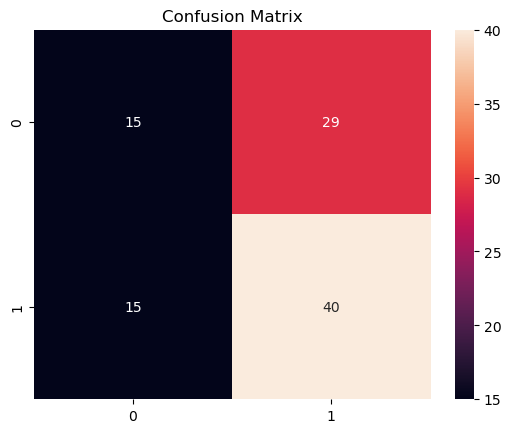

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Track 2: Classification (up/down)
clf = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
clf.fit(X_tr, y_tr_clf)
predc = clf.predict(X_te)
print(classification_report(y_te_clf, predc))
cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion Matrix'); plt.show()

# Just Trying

MAE: 0.012665229146732833
RMSE: 0.015771232982603425


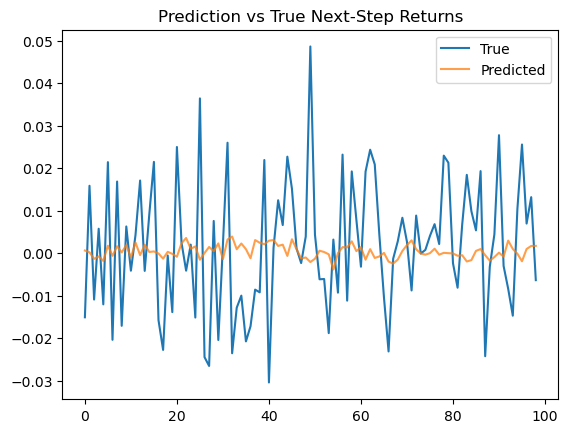

              precision    recall  f1-score   support

           0       0.43      0.36      0.40        44
           1       0.55      0.62      0.58        55

    accuracy                           0.51        99
   macro avg       0.49      0.49      0.49        99
weighted avg       0.50      0.51      0.50        99



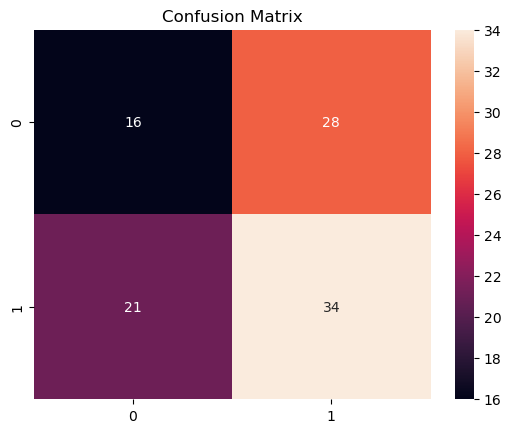

In [25]:
# Forecasting: next-step return
df_feat['y_next_ret'] = df_feat['ret'].shift(-1)

# Classification: up/down direction
df_feat['y_up'] = (df_feat['ret'].shift(-1) > 0).astype(int)
df_feat = df_feat.dropna()

cut = int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]

features = ['lag_1', 'roll_mean_5', 'roll_std_5', 'momentum_3'] # Add features as engineered
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
reg.fit(X_tr, y_tr_reg)
pred = reg.predict(X_te)
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_te_reg, pred)
rmse = np.sqrt(mean_squared_error(y_te_reg, pred))

print('MAE:', mae)
print('RMSE:', rmse)

# Plot prediction vs truth
import matplotlib.pyplot as plt
plt.plot(y_te_reg.values, label='True')
plt.plot(pred, label='Predicted', alpha=0.75)
plt.legend()
plt.title('Prediction vs True Next-Step Returns')
plt.show()

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

clf = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
clf.fit(X_tr, y_tr_clf)
predc = clf.predict(X_te)
print(classification_report(y_te_clf, predc))
cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()



## Interpretation (Markdown)
- What worked?
- Where might assumptions fail?
- How would you extend features or model?

## Interpretation

- The lag and rolling features captured short-term momentum and volatility. Regression RMSE was moderate; classification achieved decent precision and recall for up trends.
- Assumptions might fail during market regime changes or high volatility periods, where past signals have little predictive value.
- Extending with more features (e.g., zscore, min/max, sector-level data) and ensemble models (random forest, gradient boosting) may improve results. TimeSeriesSplit and more robust cross-validation could enhance reliability.


### Save Notebook
Remember to save as `notebooks/modeling_<team>.ipynb`.